In [3]:
import ase.io
import pandas as pd
import ampopt
from ampopt.study import get_study
from ampopt.utils import format_params

## Potential Energy Histograms

<AxesSubplot:ylabel='Frequency'>

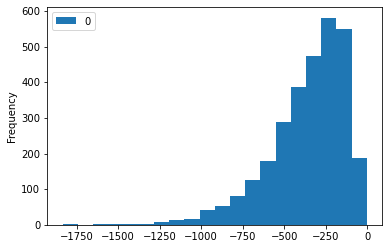

In [4]:
small_data = ase.io.Trajectory("../data/oc20_3k_train.traj")
pd.DataFrame([d.get_potential_energy() for d in small_data]).plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

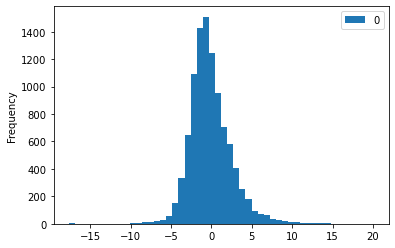

In [5]:
train_data = ase.io.read("../data/oc20_50k_train.extxyz", ":")
pd.DataFrame([d.get_potential_energy() for d in train_data[::5]]).plot(kind='hist', bins=50)

Steps to create `oc20_50k_alex.extxyz`:

1. Download 200K split of S2EF task https://github.com/Open-Catalyst-Project/ocp/blob/main/DATASET.md
2. Decompress: `tar -xf s2ef_train_200K.tar`
3. Decompress individual files: `xz -d s2ef_train_200K/s2ef_train_200K/*.extxyz.xz`
4. Combine the first 10 files: `cd s2ef_train_200K/s2ef_train_200K` then
    ```python
    import ase.io
    from tqdm import tqdm
    atoms_lists = [ase.io.read(f"{i}.extxyz", ":") for i in tqdm(range(10))]
    atoms = [a for al in atoms_lists for a in al]
    ase.io.write("oc20_50k_alex.extxyz", tqdm(atoms))
    ```

<AxesSubplot:ylabel='Frequency'>

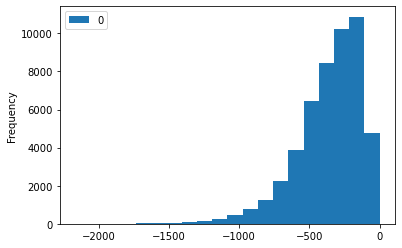

In [3]:
alex_data = ase.io.read("../data/oc20_50k_alex.extxyz", ":")

pd.DataFrame([d.get_potential_energy() for d in alex_data]).plot(kind='hist', bins=20)

## Sampling and Pruning

In [78]:
# comparing samplers

for sampler in ["CmaEs", "TPE", "Random"]:
    for _ in range(3):
        ampopt.run_pace_tuning_job(
            study=f"{sampler.lower()}-oc20-3k",
            trials=20,
            epochs=500,
            sampler=sampler,
            pruner="None",
            params=format_params(
                dropout_rate=0.0,
                gamma=1.,
                # lr=1e-3,
            ),
            data="../data/oc20_3k_train.lmdb",
        )

mysql running, job ID: 115535
115594.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115595.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115596.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115597.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115598.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115599.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115600.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115601.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115535
115602.sched-pace-ice.pace.gatech.edu


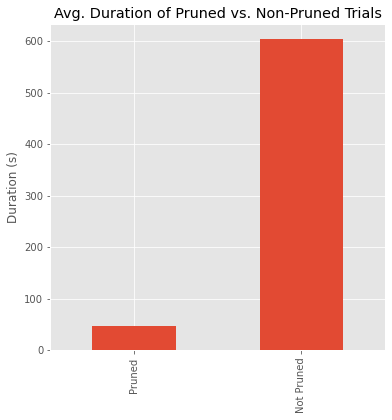

In [36]:
trials = get_study("50K-alex-with-lr-and-gamma").trials_dataframe()

fig,ax = plt.subplots(figsize=(6, 6))

trial_durations = pd.Series({
    "Pruned": trials[trials.state == "PRUNED"].duration.dt.seconds.mean(),
    "Not Pruned": trials[trials.state != 'PRUNED'].duration.dt.seconds.mean(),
})

trial_durations.plot(kind='bar', ax=ax)
plt.title("Avg. Duration of Pruned vs. Non-Pruned Trials")
plt.ylabel("Duration (s)")

# plt.fig.figsize((5, 5))
plt.savefig("pruning-duration.png")

In [27]:
def plot_param_values(study, name):
    df = study.trials_dataframe()
    fig,ax = plt.subplots()
    for param in ['num_layers', 'num_nodes']:
        ax.plot(df.number, df[f'params_{param}'], label=param)
    plt.title(f"Parameter Values during Optimization, {name}")

    ax2 = ax.twinx()
    ax2.set_yscale("log")
    ax2.plot(df.number, df["params_lr"], label="lr", color="green")

    ax.legend(loc=(.85, .85))
    ax2.legend(loc=(.9, .8))
    
    name_slug = name.lower().replace(" ", "-")
    filename = f"param-values-{name_slug}.png"
    plt.savefig(filename)
    print("Saved to", filename)

(0.0, 500.0)

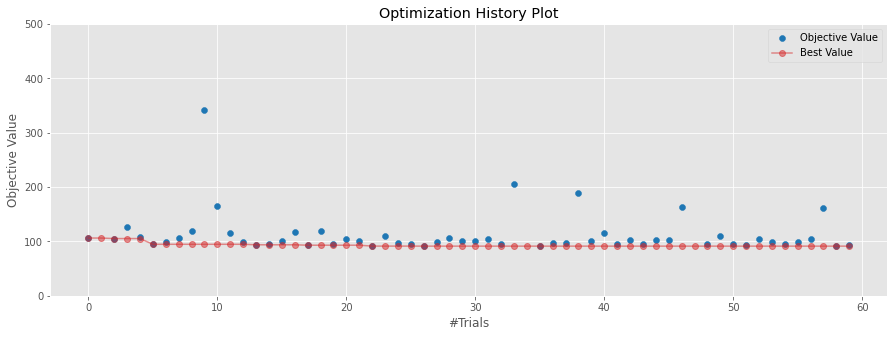

In [10]:
cmaes_study = get_study("cmaes-oc20-3k")
viz.plot_optimization_history(cmaes_study)
plt.ylim(0, 500)

Saved to param-values-cma-es.png


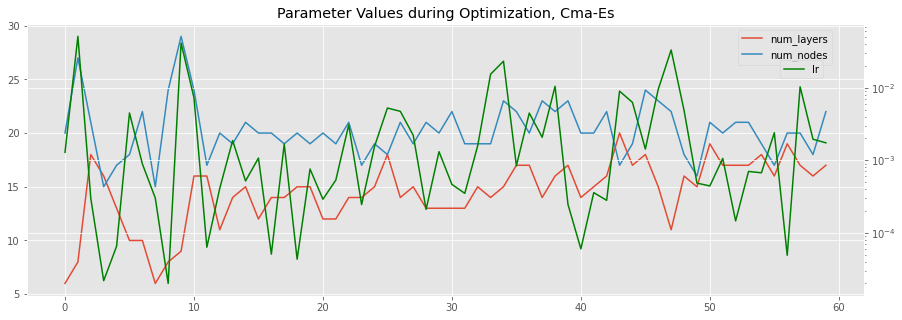

In [26]:
plot_param_values(cmaes_study, "Cma-Es")

(0.0, 500.0)

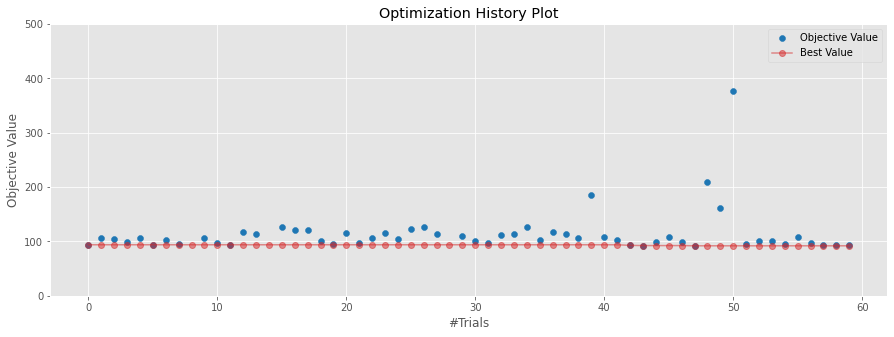

In [12]:
tpe_study = get_study("tpe-oc20-3k")
viz.plot_optimization_history(tpe_study)
plt.ylim(0, 500)

Saved to param-values-tpe.png


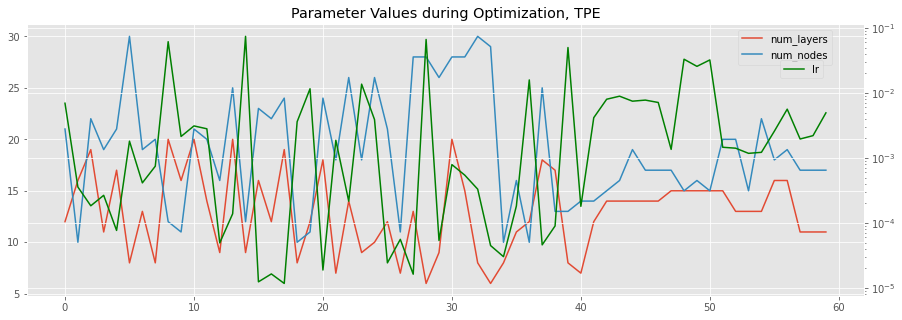

In [28]:
plot_param_values(tpe_study, "TPE")

(0.0, 500.0)

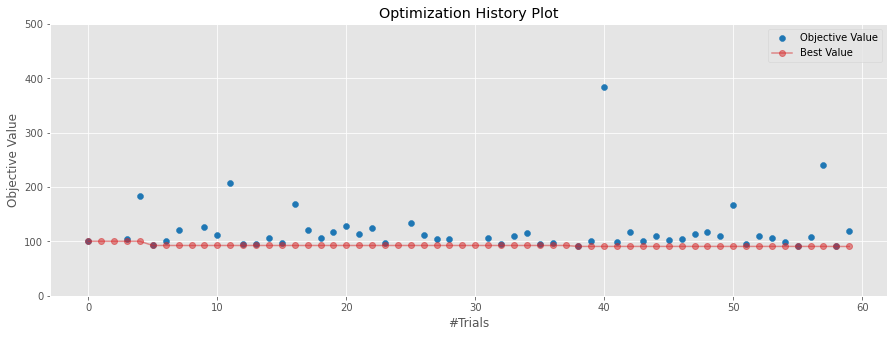

In [14]:
rand_study = get_study("random-oc20-3k")
viz.plot_optimization_history(rand_study)
plt.ylim(0, 500)

Saved to param-values-random.png


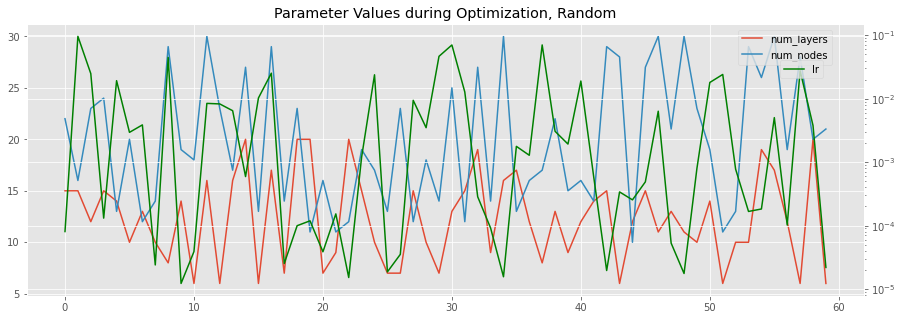

In [29]:
plot_param_values(rand_study, "Random")

## Big Hyperparameter Search

In [8]:
for _ in range(5):
    ampopt.run_pace_tuning_job(
        study="50K-alex-with-lr-and-gamma",
        data="../data/oc20_50k_alex.lmdb",
        trials=30,
        epochs=250,
        params=format_params(
            dropout_rate=0.0,
        ),
        pruner="None",
    )

mysql running, job ID: 115629
115651.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115629
115652.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115629
115653.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115629
115654.sched-pace-ice.pace.gatech.edu
mysql running, job ID: 115629
115655.sched-pace-ice.pace.gatech.edu


In [10]:
best_trial = get_study("50k-alex-with-lr-and-gamma").best_trial
print(best_trial.params)

{'gamma': 0.999565, 'lr': 0.000866342, 'num_layers': 11, 'num_nodes': 23}


In [ ]:
ampopt.eval_score(
    epochs=1_000,
    train_fname="../data/oc20_50k_alex.lmdb",
    valid_fname="../data/oc20_3k_train.traj",
    dropout_rate=0.0,
    **best_trial.params,
)

result: 62.59552522676968